# Final Project: Module 6 – Regression Analysis

**Name:** Lindsay Foster 

**Date:** 11/23/2025

# Introduction
In this project, I use regression analysis to examine how different factors contribute to insurance charges. Using the Medical Cost dataset, I explore the data, select meaningful features, and build predictive models based on variables such as age, BMI, and smoking status. The goal is to compare regression methods and evaluate how well they predict medical insurance costs.

## Imports

In [38]:
# ------------------------------------------------
# Imports once at the top, organized
# ------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

## Import and Inspect the Data

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data/insurance.csv")

# Display the first 10 rows
df.head(10)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [ ]:
# Check for missing values
df.isnull().sum()
df[df.isnull().any(axis=1)]
# There are no missing values in the dataset

,age,sex,bmi,children,smoker,region,charges


In [6]:
df.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Reflection 1: What do you notice about the dataset? Are there any data issues?
There are no missing values and the data is easy to read. 

## Data Exploration and Preparation

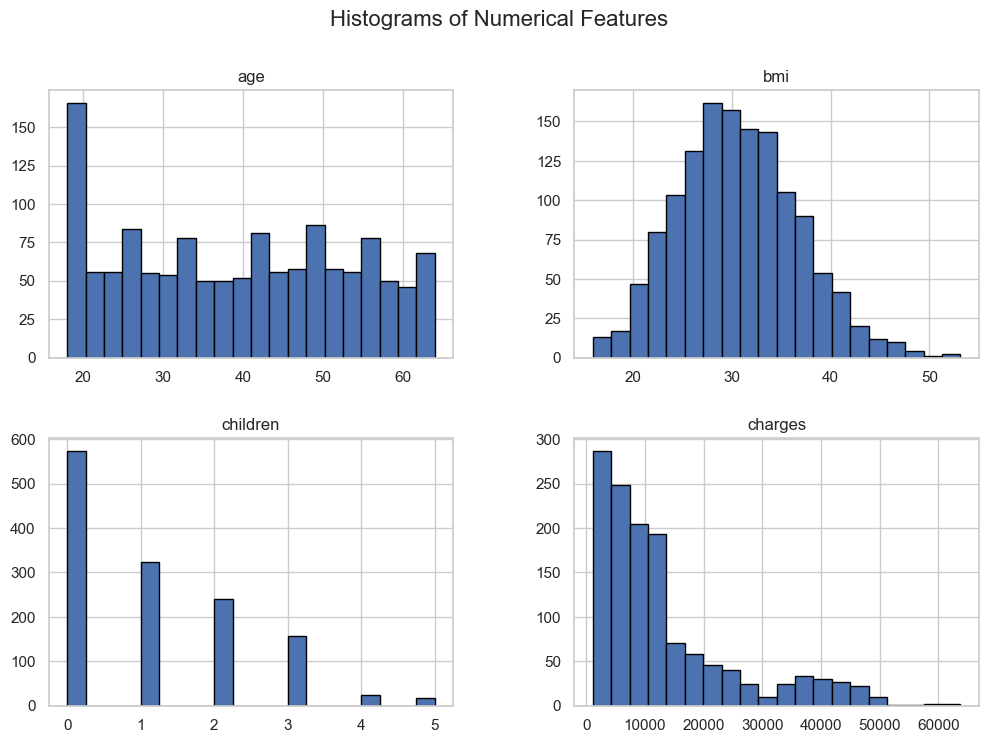

In [9]:
# Histograms for Numerical Features

# Set style
sns.set(style="whitegrid")

# Histograms
df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()


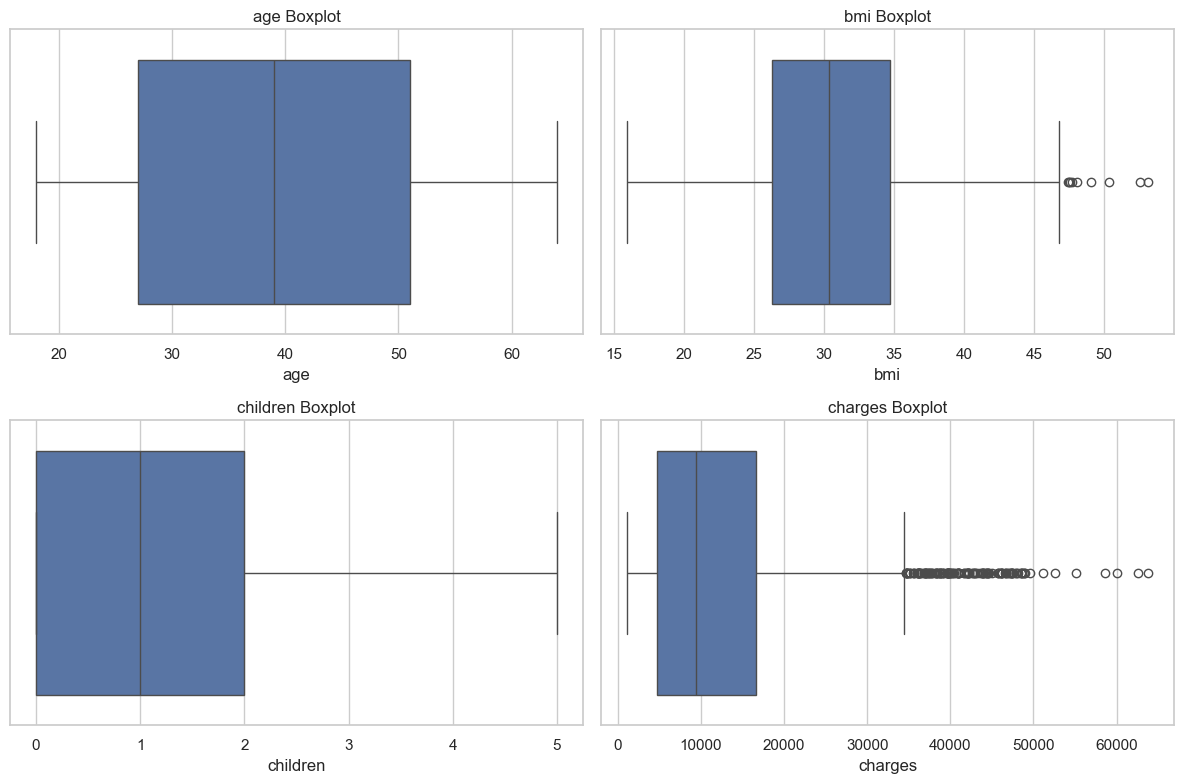

In [10]:
# Boxplots for Numerical Features

plt.figure(figsize=(12, 8))
for i, col in enumerate(['age', 'bmi', 'children', 'charges'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f"{col} Boxplot")

plt.tight_layout()
plt.show()


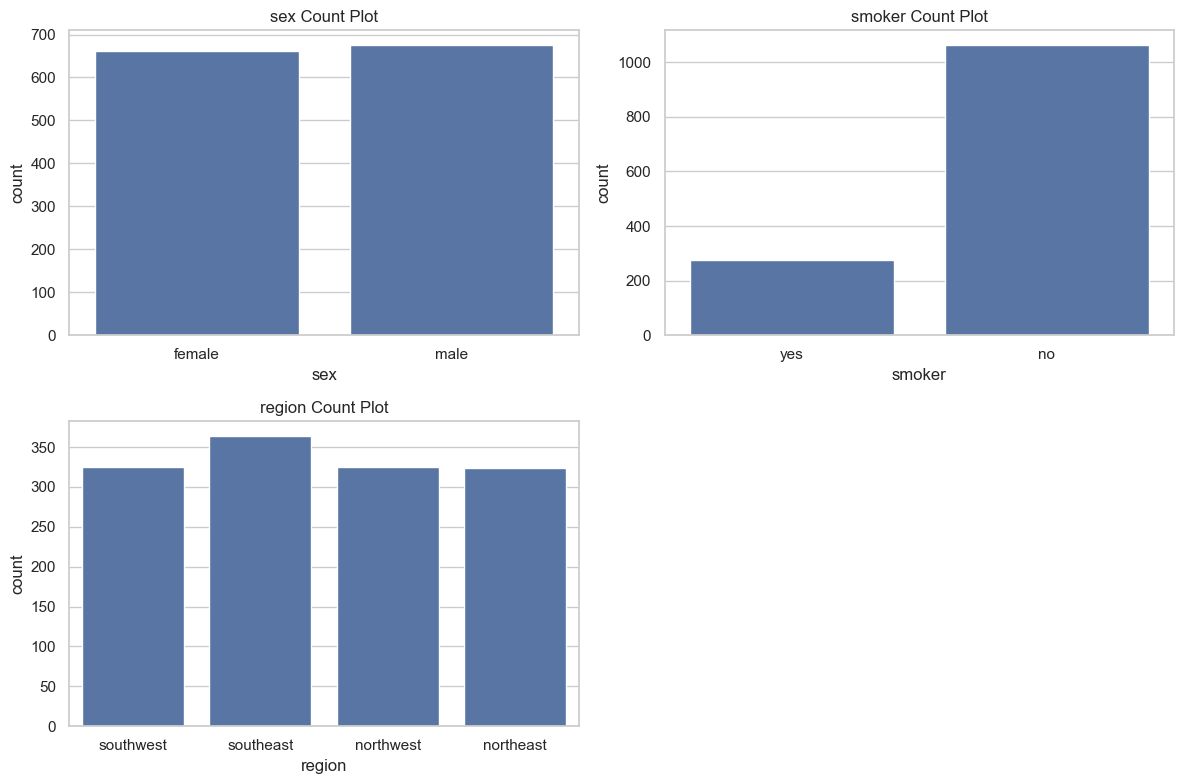

In [11]:
# Count Plots for Categorical Features

categorical_cols = ['sex', 'smoker', 'region']

plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=col)
    plt.title(f"{col} Count Plot")

plt.tight_layout()
plt.show()


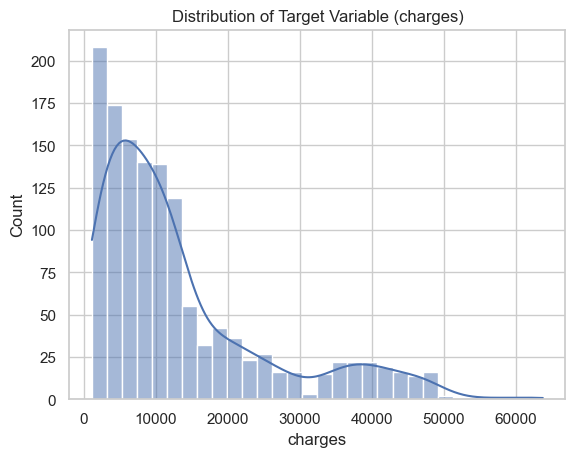

In [12]:
sns.histplot(df['charges'], kde=True)
plt.title("Distribution of Target Variable (charges)")
plt.show()


In [13]:
# Outlier Detection and Removal using IQR method

df_clean = df.copy()

for col in ['bmi', 'charges']:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

df_clean.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [14]:
# Encoding Categorical Variables

df_encoded = pd.get_dummies(df_clean, drop_first=True)
df_encoded.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [15]:
# Creating BMI Categories

df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100],
                            labels=['underweight', 'normal', 'overweight', 'obese'])
df = pd.get_dummies(df, columns=['bmi_category'], drop_first=True)


In [20]:
# Create a copy for plotting
df['bmi_category_vis'] = pd.cut(
    df['bmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['underweight', 'normal', 'overweight', 'obese']
)


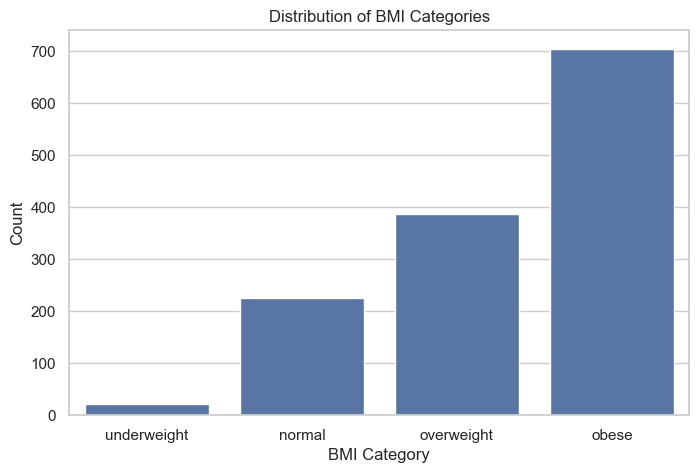

In [21]:
# Plot BMI Categories

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='bmi_category_vis', order=['underweight', 'normal', 'overweight', 'obese'])
plt.title("Distribution of BMI Categories")
plt.xlabel("BMI Category")
plt.ylabel("Count")
plt.show()


In [17]:
# Feature Scaling

scaler = StandardScaler()
numeric_cols = ['age', 'bmi', 'children', 'charges']

df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])
df_encoded.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.424190,-0.356784,-0.894220,0.972086,False,True,False,False,True
1,-1.495361,0.643537,-0.071814,-1.137965,True,False,False,True,False
2,-0.783654,0.512320,1.572998,-0.758821,True,False,False,True,False
3,-0.427801,-1.242076,-0.894220,1.681898,True,False,True,False,False
4,-0.498972,-0.189779,-0.894220,-0.839914,True,False,True,False,False


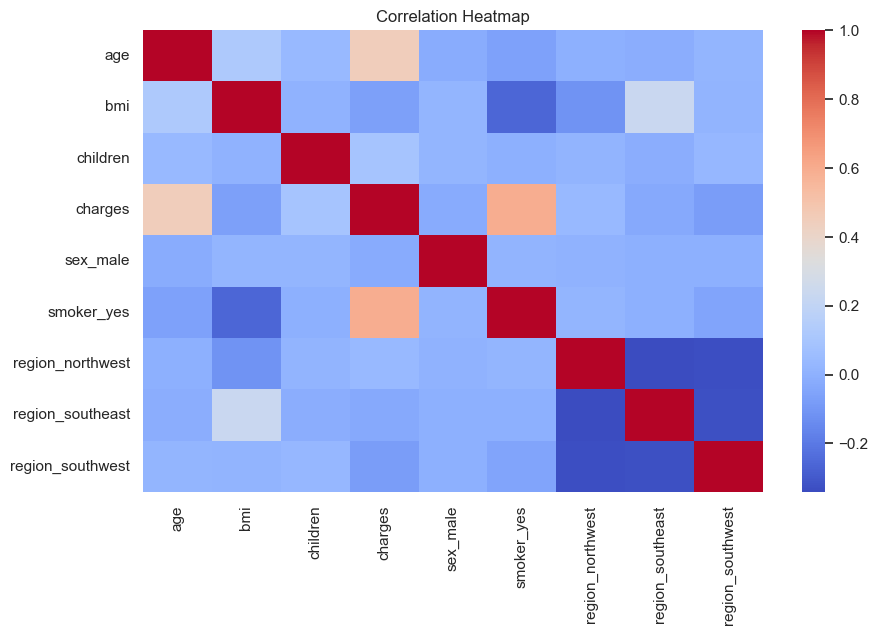

In [18]:
# Correlation Heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


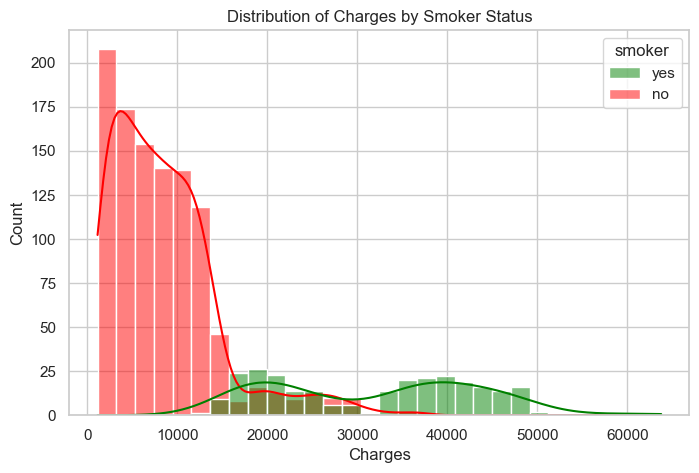

In [22]:
# Charges by Smoker Status

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='charges', hue='smoker', kde=True, bins=30, palette=['green','red'])
plt.title("Distribution of Charges by Smoker Status")
plt.xlabel("Charges")
plt.ylabel("Count")
plt.show()

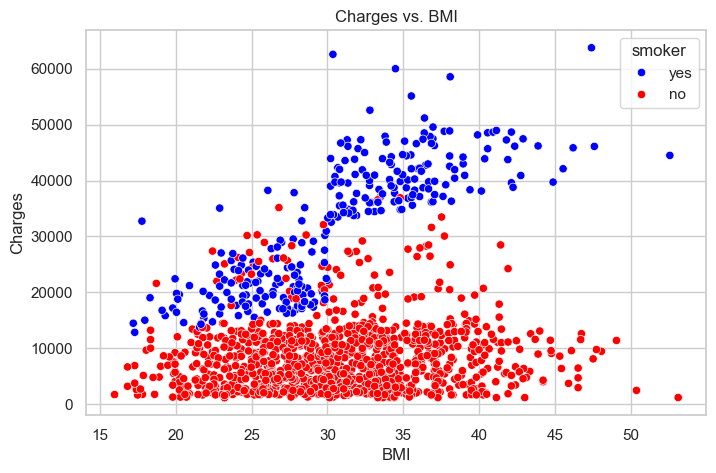

In [23]:
# Charges vs. BMI

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker', palette=['blue','red'])
plt.title("Charges vs. BMI")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()

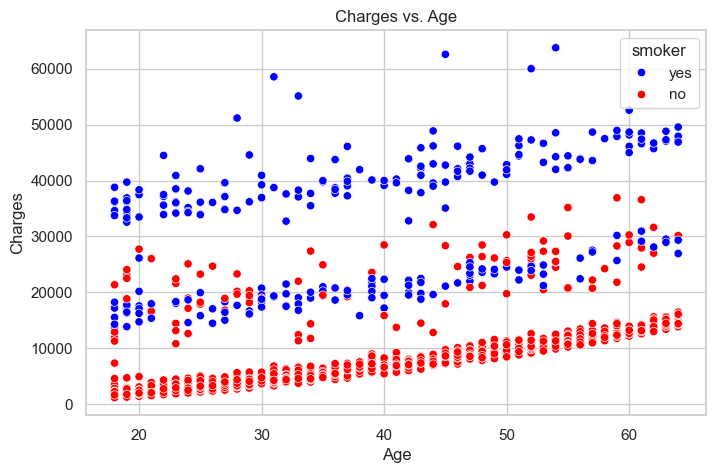

In [24]:
# Charges vs Age

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='age', y='charges', hue='smoker', palette=['blue','red'])
plt.title("Charges vs. Age")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

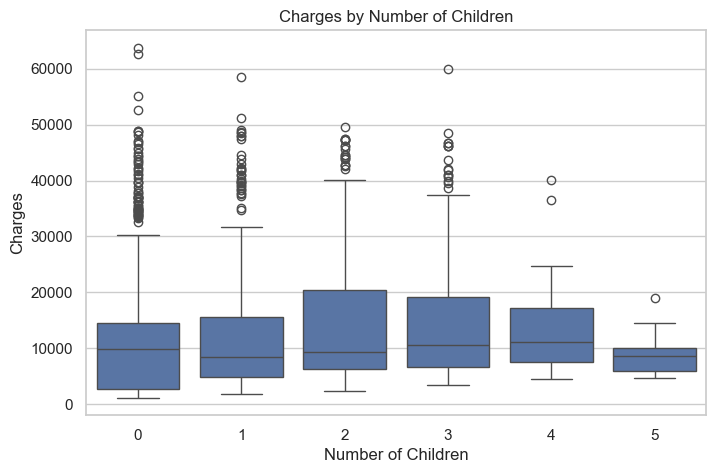

In [25]:
# Charges vs Children

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='children', y='charges')
plt.title("Charges by Number of Children")
plt.xlabel("Number of Children")
plt.ylabel("Charges")
plt.show()

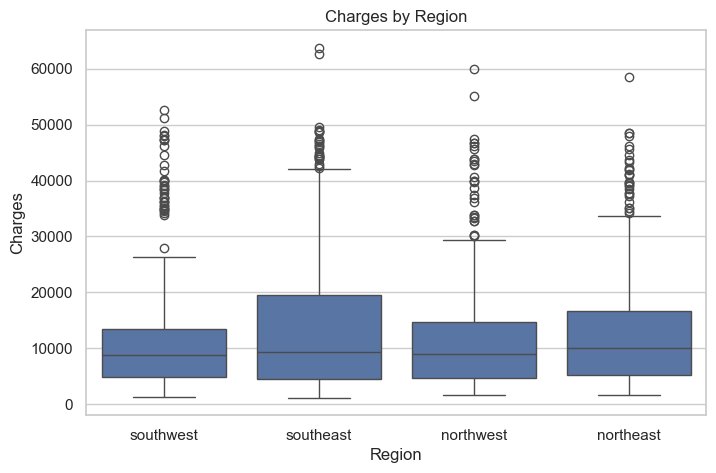

In [26]:
# Charges by Region

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='region', y='charges')
plt.title("Charges by Region")
plt.xlabel("Region")
plt.ylabel("Charges")
plt.show()

C:\Users\linds\AppData\Local\Temp\ipykernel_30008\74134239.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='smoker', y='charges', palette=['skyblue','salmon'])


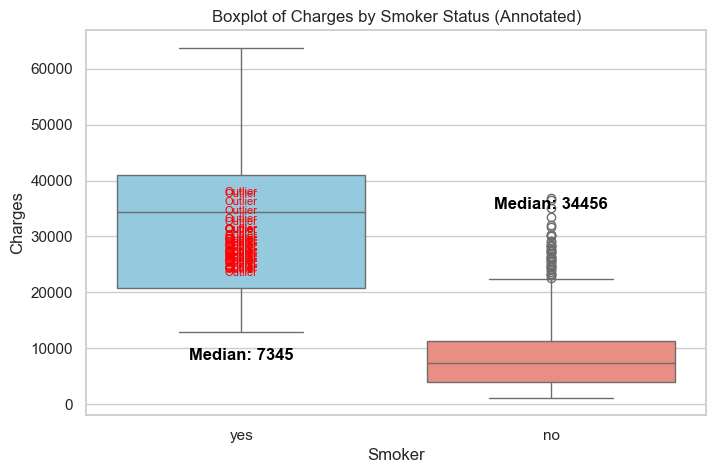

In [27]:
# Boxplot of Charges by Smoker Status with Annotations

plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=df, x='smoker', y='charges', palette=['skyblue','salmon'])

# Annotate median
medians = df.groupby('smoker')['charges'].median().values
for xtick, median in enumerate(medians):
    ax.text(xtick, median + 500, f"Median: {median:.0f}", 
            horizontalalignment='center', color='black', weight='semibold')

# Annotate outliers
smoker_groups = df.groupby('smoker')['charges']
for i, (name, group) in enumerate(smoker_groups):
    outliers = group[group > group.quantile(0.75) + 1.5*(group.quantile(0.75)-group.quantile(0.25))]
    for y in outliers:
        ax.text(i, y + 500, "Outlier", color='red', fontsize=8, ha='center')

plt.title("Boxplot of Charges by Smoker Status (Annotated)")
plt.xlabel("Smoker")
plt.ylabel("Charges")
plt.show()


C:\Users\linds\AppData\Local\Temp\ipykernel_30008\2822576510.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='region', y='charges', palette='pastel')


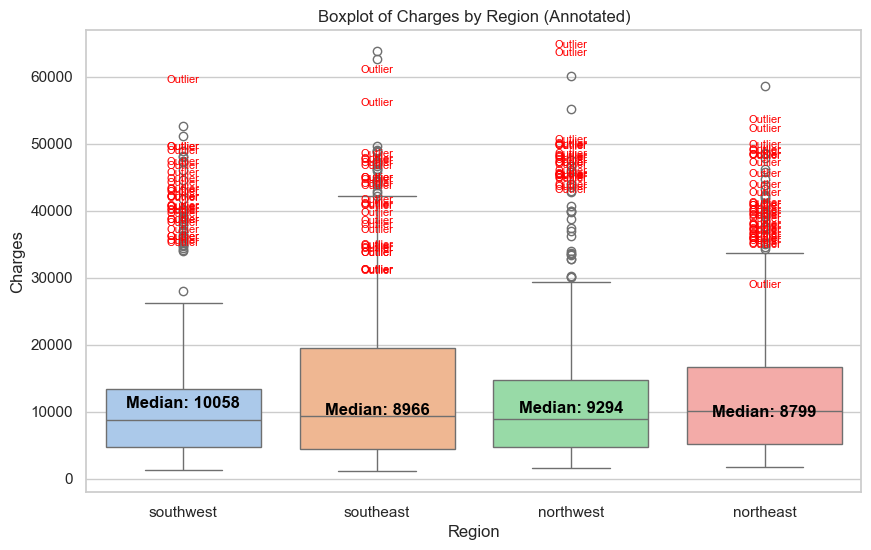

In [28]:
# Boxplot of Charges by Region with Annotations

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='region', y='charges', palette='pastel')

# Annotate median
medians = df.groupby('region')['charges'].median().values
for xtick, median in enumerate(medians):
    ax.text(xtick, median + 500, f"Median: {median:.0f}", 
            horizontalalignment='center', color='black', weight='semibold')

# Annotate outliers
region_groups = df.groupby('region')['charges']
for i, (name, group) in enumerate(region_groups):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    outliers = group[group > Q3 + 1.5*IQR]
    for y in outliers:
        ax.text(i, y + 500, "Outlier", color='red', fontsize=8, ha='center')

plt.title("Boxplot of Charges by Region (Annotated)")
plt.xlabel("Region")
plt.ylabel("Charges")
plt.show()


C:\Users\linds\AppData\Local\Temp\ipykernel_30008\224184738.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='children', y='charges', palette='coolwarm')


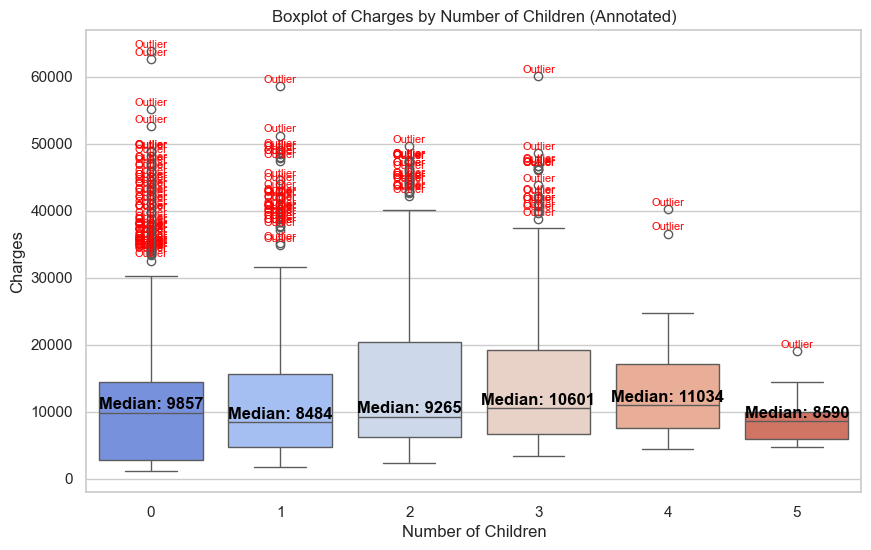

In [29]:
# Charges by Number of Children with Annotations

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='children', y='charges', palette='coolwarm')

# Annotate median
medians = df.groupby('children')['charges'].median().values
for xtick, median in enumerate(medians):
    ax.text(xtick, median + 500, f"Median: {median:.0f}", 
            horizontalalignment='center', color='black', weight='semibold')

# Annotate outliers
children_groups = df.groupby('children')['charges']
for i, (name, group) in enumerate(children_groups):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    outliers = group[group > Q3 + 1.5*IQR]
    for y in outliers:
        ax.text(i, y + 500, "Outlier", color='red', fontsize=8, ha='center')

plt.title("Boxplot of Charges by Number of Children (Annotated)")
plt.xlabel("Number of Children")
plt.ylabel("Charges")
plt.show()


## Reflection 2: What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?

Being a smoker has a direct correlation to charges no matter age, number of children, region. Smoking is a direct indicator that insurance will charge more. I did find it interesting that the number of children vs charges create more of a bell curve with 0, 1, and 5 children being charged less than 2, 3, and 4. Charges also rose along with age, however, again, smoking plays a big role in charges. BMI doesn't seem to raise charges too much, however, if you smoke and your BMI is high, the charges also increase. This data was relatively clean. I added BMI categories: underweight, normal, overweight, obese.

## Feature Selection and Justification

### Choose Features and Target

Target variable (y):charges — continuous variable representing medical insurance costs.

Reason: This is the value we want to predict using regression.

Input features (X): age (numerical) — older individuals often have higher medical costs, bmi (numerical) — higher BMI can increase health risk and charges, smoker (categorical, encoded as 0/1) — smoking strongly affects medical costs, children (numerical) — number of dependents may influence insurance charges, region (categorical, one-hot encoded) — regional cost differences may exist, sex (categorical, one-hot encoded) — gender may have minor effects on charges.

Justification:
These features were selected based on domain knowledge and initial exploration. Visualizations showed that smoker status, age, and BMI have strong relationships with charges. Children, sex, and region may provide incremental predictive power.

In [32]:
# Define target variable
y = df_encoded['charges']

# Define input features
X = df_encoded.drop(columns=['charges'])  # drop target from feature set

# Inspect shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

# Display first 5 rows of features
X.head()


X shape: (1191, 8)
y shape: (1191,)


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.424190,-0.356784,-0.894220,False,True,False,False,True
1,-1.495361,0.643537,-0.071814,True,False,False,True,False
2,-0.783654,0.512320,1.572998,True,False,False,True,False
3,-0.427801,-1.242076,-0.894220,True,False,True,False,False
4,-0.498972,-0.189779,-0.894220,True,False,True,False,False


## Reflection 3: Why did you choose these features? How might they impact predictions or accuracy?
Age, Smoker, and BMI will be the greatest indicators for charges. Sex, Children, and Region will not give us much in terms of charges, they do not differ from each other much. Children vs age may be an interesting predictor if combined but smoking is the highest predictor.

## Train a Model (Linear Regression)

In [33]:
# Split the Data into Training and Testing Sets

# Convert booleans to integers for regression
X = X.astype(int)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (952, 8) (952,)
Testing set: (239, 8) (239,)


In [35]:
# Train a Model (Linear Regression)

# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Model coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})
coefficients

,Feature,Coefficient
0,age,0.621818
1,bmi,0.088491
2,children,0.092104
3,sex_male,-0.019169
4,smoker_yes,2.065626
5,region_northwest,-0.045633
6,region_southeast,-0.151792
7,region_southwest,-0.159042


In [39]:
# Evaluate the Model

# Predict on test set
y_pred = lr_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.2f}")


Mean Squared Error: 0.48
Root Mean Squared Error: 0.69
R-squared: 0.544
Mean Absolute Error: 0.45


In [42]:
# Compare actual vs predicted charges
comparison = pd.DataFrame({
    'Actual Charges': y_test,
    'Predicted Charges': y_pred,
    'Residuals': y_test - y_pred
})
comparison.head(10)

,Actual Charges,Predicted Charges,Residuals
1069,0.143053,0.320735,-0.177682
282,-0.788376,-0.168460,-0.619916
299,-0.090698,-0.194924,0.104226
177,0.074466,0.294316,-0.219850
637,2.089809,-0.060800,2.150609
616,0.244560,0.472527,-0.227967
903,-0.247109,-0.231761,-0.015348
69,1.080408,1.748986,-0.668578
844,0.023795,-0.168460,0.192255
724,0.028538,-0.149291,0.177830


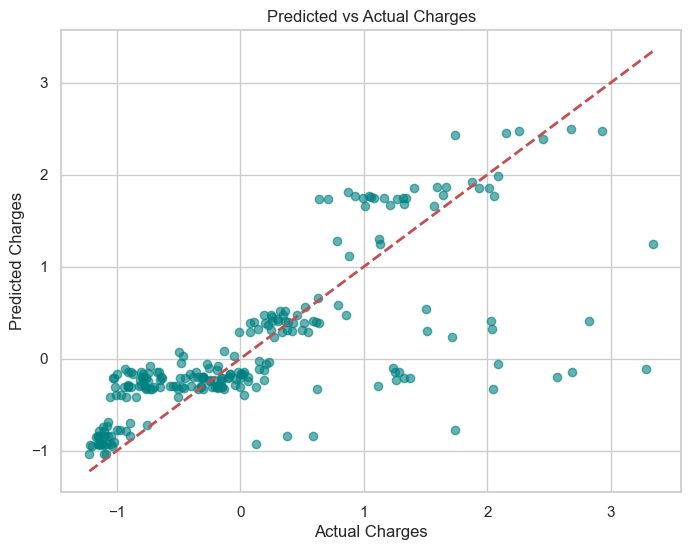

In [ ]:
# Plot Predicted vs Actual Charges

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs Actual Charges")
plt.show()

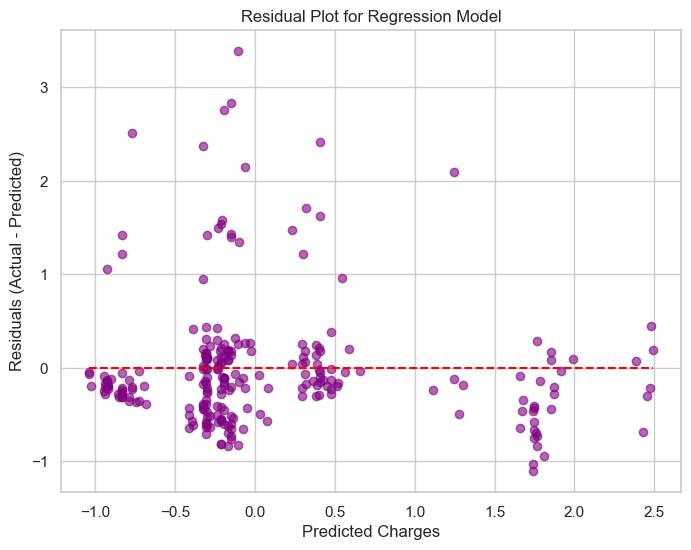

In [41]:
# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='dashed')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot for Regression Model")
plt.show()

## Reflection 4: How well did the model perform? Any surprises in the results?